In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/kaggle/input/stoxx-2014-2024/STOXX - 2014-2024.csv')
data = data.drop(columns='Close')

In [3]:
data.head()

,Date,Open,High,Low,Adj Close,Volume
0,2014-01-03,326.140015,328.089996,325.279999,327.640015,220228300.0
1,2014-01-06,327.100006,328.119995,326.510010,326.980011,194489900.0
2,2014-01-07,327.230011,329.750000,326.679993,329.399994,344684700.0
3,2014-01-08,329.529999,329.910004,328.779999,329.750000,378094300.0
4,2014-01-09,329.790009,330.950012,327.820007,328.410004,356556600.0


# Identifying and Handling outliers

In [4]:
def handling_outliers(df):
    outliers_info = {}
    for column in df.select_dtypes(include = ['number']).columns.to_list():
        mean = df[column].mean()
        std = df[column].std()
        outliers = df[(df[column] < mean-3*std) | (df[column] > mean+3*std)]
        outliers_info[column] = len(outliers)
        median = df[column].median()
        df.loc[(df[column] < mean-3*std) | (df[column] > mean+3*std), column] = median
    return outliers_info, df


outliers_info, data = handling_outliers(data)

In [5]:
outliers_info

{'Open': 0, 'High': 0, 'Low': 0, 'Adj Close': 0, 'Volume': 36}

# Handling missing values

In [6]:
missing_values = data.isnull().sum().sum()
missing_values

10

In [7]:
data.interpolate(method='linear', inplace=True)

<ipython-input-7-6d64e3ce7f8a>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', inplace=True)


In [8]:
data.isnull().sum().sum()

0

# ARIMA 

## Initial Analysis

In [12]:
data['Date'] = pd.to_datetime(data['Date'])

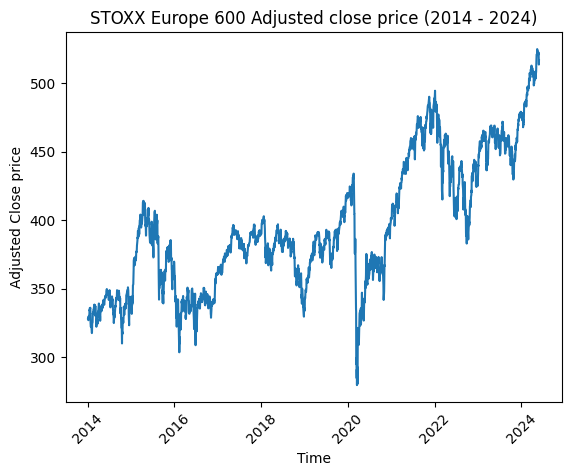

In [41]:
plt.plot(data['Date'], data['Adj Close'])
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Adjusted Close price')
plt.title('STOXX Europe 600 Adjusted close price (2014 - 2024)')
plt.show()

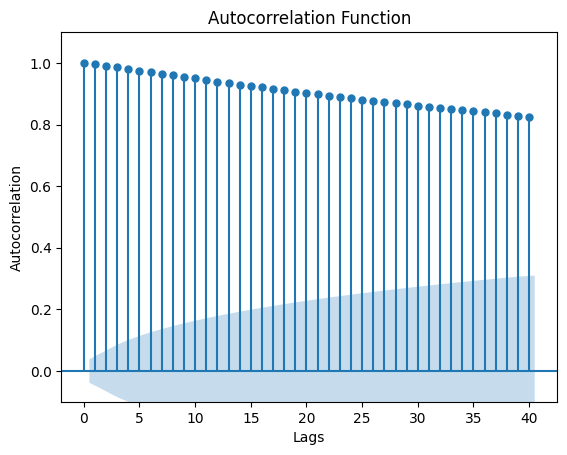

In [42]:
plot_acf(data['Adj Close'], lags=40, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.ylim(-0.1, 1.1)
plt.show()

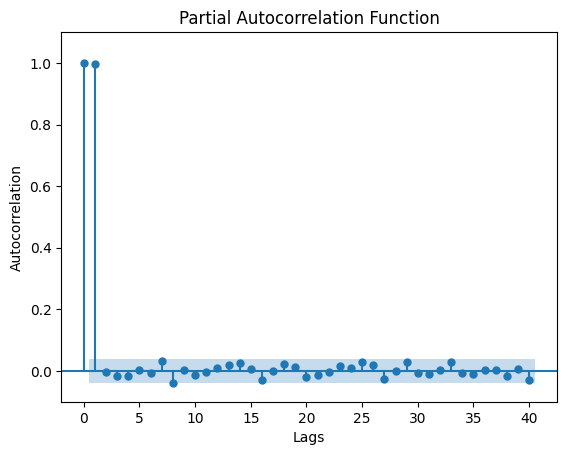

In [43]:
plot_pacf(data['Adj Close'], lags=40, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation Function')
plt.ylim(-0.1, 1.1)
plt.show()

In [44]:
ad_full_result = adfuller(data['Adj Close'])
adf_results = pd.DataFrame({
    'Metric': [
        'ADF Statistic',
        'p-value',
        'Number of lags used',
        'Number of observations used'
    ],
    'Value': [
        round(ad_full_result[0], 3),
        round(ad_full_result[1], 3),
        ad_full_result[2],
        ad_full_result[3]
    ]
})

adf_results

## First Differencing

In [46]:
data.set_index('Date', inplace=True)
stoxx_diff = data['Adj Close'].diff()
#stoxx_diff = pd.DataFrame(stoxx_diff, index=stoxx_diff.index)

Text(0.5, 1.0, 'First-differenced STOXX Europe 600')

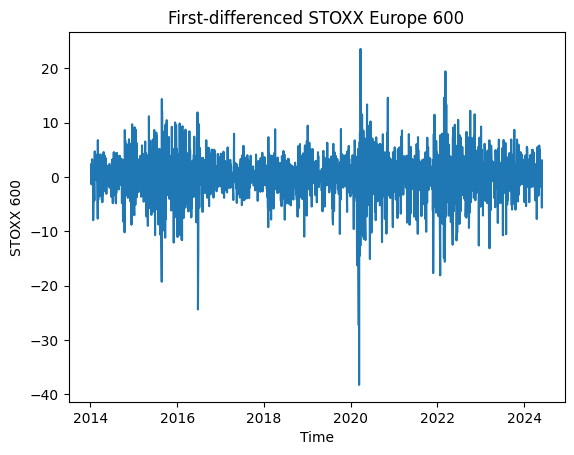

In [48]:
plt.plot(stoxx_diff)
plt.xlabel('Time')
plt.ylabel('STOXX 600')
plt.title('First-differenced STOXX Europe 600')

In [52]:
stoxx_diff = stoxx_diff.dropna()

In [53]:
ad_full_result_diff = adfuller(stoxx_diff)
adf_results_diff = pd.DataFrame({
    'Metric': [
        'ADF Statistic',
        'p-value',
        'Number of lags used',
        'Number of observations used'
    ],
    'Value': [
        round(ad_full_result_diff[0], 3),
        round(ad_full_result_diff[1], 3),
        ad_full_result_diff[2],
        ad_full_result_diff[3]
    ]
})

adf_results_diff

,Metric,Value
0,ADF Statistic,-18.924
1,p-value,0.000
2,Number of lags used,6.000
3,Number of observations used,2608.000


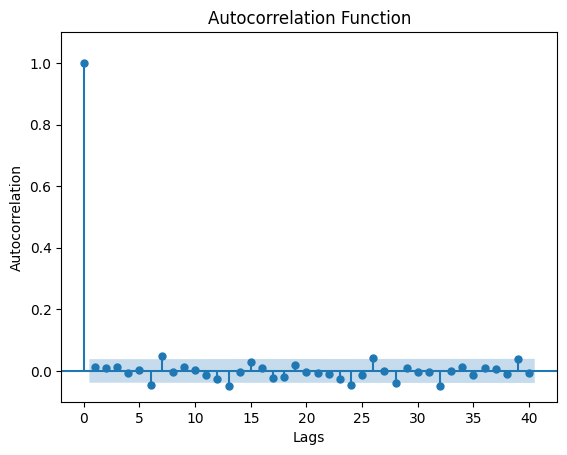

In [54]:
plot_acf(stoxx_diff, lags=40, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.ylim(-0.1, 1.1)
plt.show()

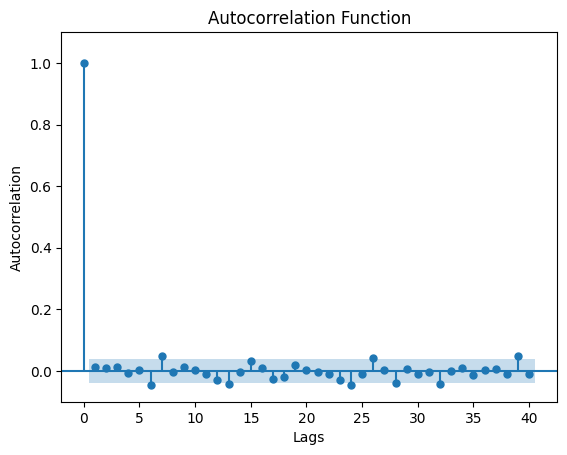

In [55]:
plot_pacf(stoxx_diff, lags=40, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.ylim(-0.1, 1.1)
plt.show()

## Model selection

In [56]:
warnings.filterwarnings('ignore')

p_range = range(0, 6)
d_range = [0, 1]
q_range = range (0, 6)

series = data['Adj Close']

train_size = int(len(series)*0.8)
train_series = series[:train_size]
test_series = series[train_size:]

result = []

for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(train_series, order=(p,d,q))
                res = model.fit()
    
                BIC = res.bic
    
                result.append({
                    'p': p,
                    'd': d,
                    'q': q,
                    'BIC': BIC
                })
            except Exception as e:
                print(e)
                continue

result_df = pd.DataFrame(result)
sorted_results = result_df.sort_values(by='BIC')

print(sorted_results)

    p  d  q           BIC
6   0  1  0  11679.403704
18  1  1  0  11686.941716
7   0  1  1  11686.943681
30  2  1  0  11694.400162
8   0  1  2  11694.405479
.. .. .. ..           ...
4   0  0  4  14873.068803
3   0  0  3  15620.561091
2   0  0  2  16952.951761
1   0  0  1  18782.900047
0   0  0  0  21419.001103

[72 rows x 4 columns]


In [57]:
warnings.filterwarnings('ignore')

p_range = range(0, 6)
d_range = [0, 1]
q_range = range (0, 6)

series = data['Adj Close']

train_size = int(len(series)*0.8)
train_series = series[:train_size]
test_series = series[train_size:]

result = []

for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(train_series, order=(p,d,q))
                res = model.fit()
    
                AIC = res.aic
    
                result.append({
                    'p': p,
                    'd': d,
                    'q': q,
                    'AIC': AIC
                })
            except Exception as e:
                print(e)
                continue

result_df = pd.DataFrame(result)
sorted_results = result_df.sort_values(by='AIC')

print(sorted_results)

    p  d  q           AIC
70  5  1  4  11660.741695
59  4  1  5  11664.797308
35  2  1  5  11664.872190
44  3  1  2  11671.730528
33  2  1  3  11671.766533
.. .. .. ..           ...
4   0  0  4  14839.193548
3   0  0  3  15592.331712
2   0  0  2  16930.368258
1   0  0  1  18765.962419
0   0  0  0  21407.709351

[72 rows x 4 columns]


## Residuals check

Text(0.5, 1.0, 'Residuals - ARIMA(0,1,0)')

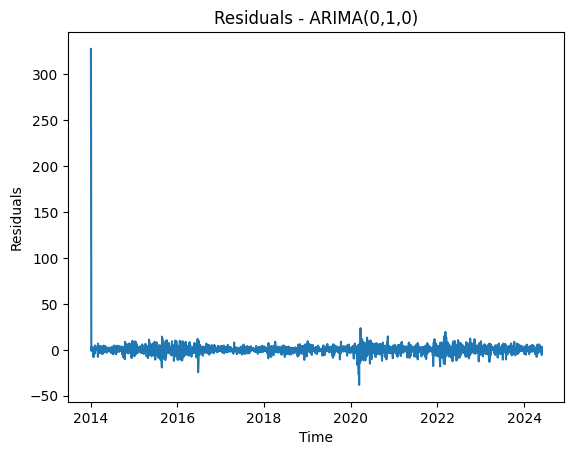

In [60]:
# Best configurations for ARIMA: (p,d,q) --> (0,1,0) & (5,1,4)

model = ARIMA(data['Adj Close'], order=(0,1,0))
arima_010_results = model.fit()
arima_010_residuals = arima_010_results.resid

plt.plot(arima_010_residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals - ARIMA(0,1,0)')

Text(0.5, 1.0, 'Residuals - ARIMA(5,1,4)')

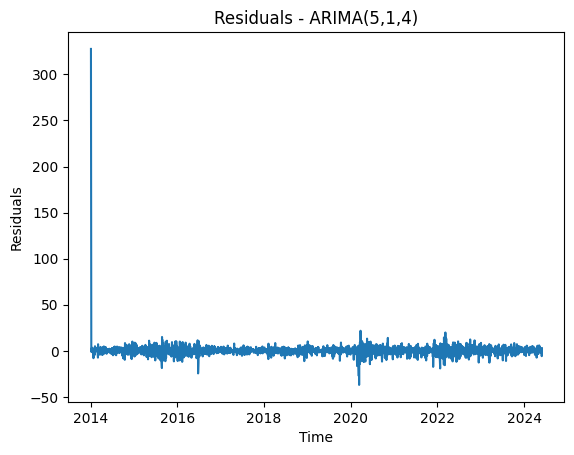

In [61]:
model = ARIMA(data['Adj Close'], order=(5,1,4))
arima_514_results = model.fit()
arima_514_residuals = arima_514_results.resid

plt.plot(arima_514_residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals - ARIMA(5,1,4)')

## Prediction and model evaluation

In [13]:
def mean_absolute_percentage_error(y_pred, y_true):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    nonzero_indices = y_true != 0
    if not np.any(nonzero_indices):
        return np.inf
    return np.mean(np.abs((y_pred[nonzero_indices] - y_true[nonzero_indices]) / y_true[nonzero_indices] )) * 100


train_size = int(len(data)*0.8)
train_sample, test_sample = data['Adj Close'][:train_size], data['Adj Close'][train_size:]

In [14]:
def rolling_forecast_1_day_ahead(train, test, order=(0,0,0)):
    history = list(train)
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast(steps=1)
        pred = output[-1]
    
        predictions.append(pred)
    
        history.append(test.iloc[t])

    return predictions

predictions_1_day_ahead_010 = rolling_forecast_1_day_ahead(train_sample, test_sample, (0,1,0))
predictions_1_day_ahead_111 = rolling_forecast_1_day_ahead(train_sample, test_sample, (1,1,1))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [16]:
mape_010_1_day = mean_absolute_percentage_error(predictions_1_day_ahead_010, test_sample)
rmse_010_1_day = mean_squared_error(test_sample, predictions_1_day_ahead_010)
mae_010_1_day = mean_absolute_error(test_sample, predictions_1_day_ahead_010)
r2_010_1_day = r2_score(test_sample, predictions_1_day_ahead_010)

mape_111_1_day = mean_absolute_percentage_error(predictions_1_day_ahead_111, test_sample)
rmse_111_1_day = mean_squared_error(test_sample, predictions_1_day_ahead_111)
mae_111_1_day = mean_absolute_error(test_sample, predictions_1_day_ahead_111)
r2_111_1_day = r2_score(test_sample, predictions_1_day_ahead_111)

print('Evaluation Metrics (1 day ahead) - ARIMA(0, 1, 0)\n')
print(f"RMSE: {rmse_010_1_day}")
print(f"MAPE: {mape_010_1_day}")
print(f"MAE: {mae_010_1_day}")
print(f"R^2: {r2_010_1_day}")

print('\n\n')
print('Evaluation Metrics (1 day ahead) - ARIMA(1, 1, 1)\n')
print(f"RMSE: {rmse_111_1_day}")
print(f"MAPE: {mape_111_1_day}")
print(f"MAE: {mae_111_1_day}")
print(f"R^2: {r2_111_1_day}")

Evaluation Metrics (1 day ahead) - ARIMA(0, 1, 0)

RMSE: 13.83992049084953
MAPE: 0.6320651066594701
MAE: 2.80696583778626
R^2: 0.9846767642304546



Evaluation Metrics (1 day ahead) - ARIMA(1, 1, 1)

RMSE: 13.878799991442483
MAPE: 0.633439259437182
MAE: 2.8139087935154348
R^2: 0.9846337177581441


In [20]:
def rolling_forecast_7_days_ahead(train, test, order=(0,0,0)):
    history = list(train)
    predictions = []

    for t in range(len(test) - 6):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast(steps=7)
        pred = output[-1]
    
        predictions.append(pred)
    
        history.append(test.iloc[t])

    return predictions

predictions_7_days_ahead_010 = rolling_forecast_7_days_ahead(train_sample, test_sample, (0,1,0))
predictions_7_days_ahead_111 = rolling_forecast_7_days_ahead(train_sample, test_sample, (1,1,1))

In [23]:
mape_010_7_days = mean_absolute_percentage_error(predictions_7_days_ahead_010, test_sample[6:])
rmse_010_7_days = np.sqrt(mean_squared_error(test_sample[6:], predictions_7_days_ahead_010))
mae_010_7_days = mean_absolute_error(test_sample[6:], predictions_7_days_ahead_010)
r2_010_7_days = r2_score(test_sample[6:], predictions_7_days_ahead_010)

mape_111_7_days = mean_absolute_percentage_error(predictions_7_days_ahead_111, test_sample[6:])
rmse_111_7_days = np.sqrt(mean_squared_error(test_sample[6:], predictions_7_days_ahead_111))
mae_111_7_days = mean_absolute_error(test_sample[6:], predictions_7_days_ahead_111)
r2_111_7_days = r2_score(test_sample[6:], predictions_7_days_ahead_111)

print('Evaluation Metrics (7 days ahead) - ARIMA(0, 1, 0)\n')
print(f"RMSE: {rmse_010_7_days}")
print(f"MAPE: {mape_010_7_days}")
print(f"MAE: {mae_010_7_days}")
print(f"R^2: {r2_010_7_days}")

print('\n\n')
print('Evaluation Metrics (7 days ahead) - ARIMA(1, 1, 1)\n')
print(f"RMSE: {rmse_111_7_days}")
print(f"MAPE: {mape_111_7_days}")
print(f"MAE: {mae_111_7_days}")
print(f"R^2: {r2_111_7_days}")

Evaluation Metrics (7 days ahead) - ARIMA(0, 1, 0)

RMSE: 99.60117221710651
MAPE: 1.7838977309234862
MAE: 7.910714218146716
R^2: 0.8904328585204174



Evaluation Metrics (7 days ahead) - ARIMA(1, 1, 1)

RMSE: 100.3150689746264
MAPE: 1.7994392173404852
MAE: 7.991386166754709
R^2: 0.8896475301423288


In [24]:
def rolling_forecast_30_days_ahead(train, test, order=(0,0,0)):
    history = list(train)
    predictions = []

    for t in range(len(test) - 29):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast(steps=30)
        pred = output[-1]
    
        predictions.append(pred)
    
        history.append(test.iloc[t])

    return predictions

predictions_30_days_ahead_010 = rolling_forecast_30_days_ahead(train_sample, test_sample, (0,1,0))
predictions_30_days_ahead_111 = rolling_forecast_30_days_ahead(train_sample, test_sample, (1,1,1))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [26]:
mape_010_30_days = mean_absolute_percentage_error(predictions_30_days_ahead_010, test_sample[29:])
rmse_010_30_days = np.sqrt(mean_squared_error(test_sample[29:], predictions_30_days_ahead_010))
mae_010_30_days = mean_absolute_error(test_sample[29:], predictions_30_days_ahead_010)
r2_010_30_days = r2_score(test_sample[29:], predictions_30_days_ahead_010)

mape_111_30_days = mean_absolute_percentage_error(predictions_30_days_ahead_111, test_sample[29:])
rmse_111_30_days = np.sqrt(mean_squared_error(test_sample[29:], predictions_30_days_ahead_111))
mae_111_30_days = mean_absolute_error(test_sample[29:], predictions_30_days_ahead_111)
r2_111_30_days = r2_score(test_sample[29:], predictions_30_days_ahead_111)

print('Evaluation Metrics (30 days ahead) - ARIMA(0, 1, 0)\n')
print(f"RMSE: {rmse_010_30_days}")
print(f"MAPE: {mape_010_30_days}")
print(f"MAE: {mae_010_30_days}")
print(f"R^2: {r2_010_30_days}")

print('\n\n')
print('Evaluation Metrics (30 days ahead) - ARIMA(1, 1, 1)\n')
print(f"RMSE: {rmse_111_30_days}")
print(f"MAPE: {mape_111_30_days}")
print(f"MAE: {mae_111_30_days}")
print(f"R^2: {r2_111_30_days}")

Evaluation Metrics (30 days ahead) - ARIMA(0, 1, 0)

RMSE: 412.04590003413523
MAPE: 3.656133422713991
MAE: 16.27482829090909
R^2: 0.5565541025700849



Evaluation Metrics (30 days ahead) - ARIMA(1, 1, 1)

RMSE: 433.72464310313205
MAPE: 3.8109365386663834
MAE: 17.061259843821258
R^2: 0.533223328802921


# Normalization

In [9]:
def normalization(df):
    for column in df.select_dtypes(include=['number']).columns:
        df[column] = (df[column] - df[column].min())/(df[column].max() - df[column].min()) 
    return df

data = normalization(data)

data.head()

,Date,Open,High,Low,Adj Close,Volume
0,2014-01-03,0.196548,0.168150,0.222733,0.195797,0.464557
1,2014-01-06,0.200428,0.168276,0.227564,0.193103,0.410264
2,2014-01-07,0.200954,0.175151,0.228231,0.202979,0.727090
3,2014-01-08,0.210250,0.175826,0.236479,0.204407,0.797565
4,2014-01-09,0.211301,0.180212,0.232709,0.198939,0.752133


# LSTM

## Fine Tuning

- Optimizer: Adam
- Activation functions: tanh for hidden layers; sigmoid for gates
- Batch size: 32
- 3 layers:
    - first one: [32, 64, 128, 256]
    - second one: [32, 64, 128, 256]
    - third one: [1]
- dropout: [0.1; 0.5]
- look-back period: [3, 8, 14, 30]
- learning rate: [0.01, 0.001, 0.0001]


In [16]:
def create_lstm_sequence(x_data, y_data, time_steps):
    x, y = [], []
    for i in range(len(x_data) - time_steps):
        x.append(x_data.iloc[i:i+time_steps].values)
        y.append(y_data.iloc[i+time_steps])
    return np.array(x), np.array(y)


x_tuning_train = pd.DataFrame(x_tuning_train)
y_tuning_train = pd.DataFrame(y_tuning_train)
x_tuning_train_reshaped, y_tuning_train_reshaped = create_lstm_sequence(x_tuning_train, y_tuning_train, time_steps)

In [18]:
x_val = pd.DataFrame(x_val)
y_val = pd.DataFrame(y_val)

In [21]:
x_val.iloc[t+time_steps:t+time_steps+6].values.reshape()

array([[0.58612885, 0.57416378, 0.59761994, 0.43338447],
       [0.80421952, 0.79401955, 0.78472958, 0.47152073],
       [0.2503839 , 0.21610217, 0.26118379, 0.71885852],
       [0.64812867, 0.64004049, 0.66089312, 0.17962577],
       [0.55169351, 0.54147853, 0.54495113, 0.45196838],
       [0.66833723, 0.65383151, 0.67420766, 0.36691596]])

In [19]:
units_layer1 = [64, 128, 256]
units_layer2 = [32, 64, 128]

time_steps = 3

for unit in units_layer1:
    for unit2 in units_layer2:
        if unit2 > unit:
            continue
        print(f"Training for {unit} units in the first layer and {unit2} units in the second layer")
        model = Sequential()
        model.add(LSTM(units=unit, return_sequences=True, input_shape=(time_steps, x_tuning_train.shape[1]), activation='tanh', recurrent_activation='sigmoid'))
        model.add(Dropout(0.1))
        model.add(LSTM(units=unit2, return_sequences=False, activation='tanh', recurrent_activation='sigmoid'))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(x_tuning_train_reshaped, y_tuning_train_reshaped, batch_size=32, epochs=100, verbose=0)

        
        predictions_1_ahead = []
        for t in range(len(y_val) - time_steps):
            predicted_1_ahead = model.predict(x_val.iloc[t+time_steps:t+time_steps+1].values.reshape(1, time_steps, x_val.shape[1]))  #check whether to start from t or t + time_steps
            predictions_1_ahead.append(predicted_1_ahead[0, 0])

        rmse_1_ahead = np.sqrt(mean_squared_error(y_val.iloc[time_steps:], predictions_1_ahead))
        
        predictions_7_ahead = []
        for t in range(len(y_val) - time_steps - 6):
            print(x_val.iloc[t+time_steps:t+time_steps+6].values.reshape(1, time_steps, x_val.shape[1]))
            predicted_7_ahead = model.predict(x_val.iloc[t+time_steps:t+time_steps+6].values.reshape(1, time_steps, x_val.shape[1])) 
            predictions_7_ahead.append(predicted_7_ahead[0, 0])
            print(f"the prediction for 7 days ahead is the following: {predicted_7_ahead}")
        rmse_7_ahead = np.sqrt(mean_squared_error(y_val.iloc[time_steps+7-1:], predictions_7_ahead))

        predictions_30_ahead = []
        for t in range(len(y_val) - time_steps - 29):
            predicted_30_ahead = model.predict(x_val.iloc[t:t+time_steps+29].values.reshape(1, time_steps, x_val.shape[1]))
            predictions_30_ahead.append(predicted_30_ahead[0, 0])

        rmse_30_ahead = np.sqrt(mean_squared_error(y_val.iloc[time_steps+30-1:], predictions_30_ahead))

        
        mean_rmse = np.mean([rmse_1_ahead, rmse_7_ahead, rmse_30_ahead])

        print(f"The average RMSE for {unit} and {unit2} units is {mean_rmse}")

Training for 64 units in the first layer and 32 units in the second layer


ValueError: cannot reshape array of size 24 into shape (1,3,4)

# Time Series Neural Network

- Optimizator: Adam
- Batch size: 32
- Look-back period: [3, 8, 14, 30]
- Kernel size (following LB period): [2, 3, 5, 7]
- Number of kernels and number of neurons for time attention layer and hidden layer: [32, 64, 128]
- Learning rate: [0.01, 0.001, 0.0001]
- Dropout: [0.1;0.5]
- Activation function: []

## Further data preparation

In [61]:
torch.manual_seed(42)
np.random.seed(42)

In [11]:
features = data[['Open', 'High', 'Low', 'Volume']].values
labels = data[['Adj Close']].values

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
x_tuning_train, x_val, y_tuning_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [63]:
class TSdataset(Dataset):
    def __init__(self, features, labels, sequence_length, prediction_horizon):
      self.features = features  
      self.labels = labels  
      self.sequence_length = sequence_length  
      self.prediction_horizon = prediction_horizon

    def __len__(self):
        return len(self.features) - self.sequence_length - self.prediction_horizon + 1

    def __getitem__(self, idx):
        return (self.features[idx:idx + self.sequence_length], self.labels[idx + self.sequence_length + self.prediction_horizon - 1])

def create_dataloader(features_train, labels_train, features_val, labels_val, sequence_length, prediction_horizon):
    train_dataset = TSdataset(features_train, labels_train, sequence_length, prediction_horizon)
    val_dataset = TSdataset(features_val, labels_val, sequence_length, prediction_horizon)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader
    

In [27]:
print(len(data), len(x_tuning_train), len(y_tuning_train), len(x_val), len(y_val))

2616 1673 1673 419 419


In [64]:
class TNN(nn.Module):
    def __init__(self, input_size, kernel_output_size, kernel_size, hidden_size, output_size, activation_function, dropout_rate):
        super().__init__()
        self.kernel_filter = nn.Conv1d(in_channels=input_size, out_channels=kernel_output_size, kernel_size=kernel_size)

        self.fc1 = nn.Linear(kernel_output_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.activation_function = activation_function
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.kernel_filter(x)
        x = torch.relu(x)

        x = torch.sum(x, dim=2)

        x = self.fc1(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def train_and_validate(model, train_loader, val_loader, optimizer, epochs):
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.float(), labels.float().unsqueeze(1)
            outputs = model(features)
            loss = criterion(outputs, labels.squeeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_predictions, val_targets = [], []
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.float(), labels.float().unsqueeze(1)
                outputs = model(features)
                val_predictions.extend(outputs.numpy())
                val_targets.extend(labels.numpy())
        
        val_rmse = np.sqrt(np.mean((np.array(val_targets) - np.array(val_predictions))**2))

    return val_rmse




def get_kernel_size(sequence_length):
    if sequence_length == 3:
        return 2
    elif sequence_length == 8:
        return 3
    elif sequence_length == 14:
        return 5
    elif sequence_length == 30:
        return 7
    else:
        return 11



def grid_search(hidden_sizes, activations, dropouts, sequence_lengths, learning_rates):
    best_val_rmse = float('inf')
    best_params = None

    activation_map = {'relu': torch.relu, 'sigmoid': torch.sigmoid, 'tanh': torch.tanh}
    horizons = [1, 7, 30]

    for hidden_size in hidden_sizes:
        for activation_func in activations:
            for dropout_rate in dropouts:
                for seq_len in sequence_lengths:
                    for lr in learning_rates:
                        kernel_size = get_kernel_size(seq_len)
                        print(f"Testing with hidden_size={hidden_size}, activation={activation_func}, sequence_length={seq_len}, kernel_size={kernel_size}, lr={lr}")
                        
                        model = TNN(input_size=4, kernel_output_size=32, kernel_size=kernel_size, hidden_size=hidden_size, output_size=1, activation_function=activation_map[activation_func], dropout_rate=dropout_rate)
                        optimizer = optim.Adam(model.parameters(), lr=lr)

                        avg_rmse = 0
                        for horizon in horizons:
                            train_loader, val_loader = create_dataloader(x_tuning_train, y_tuning_train, x_val, y_val, seq_len, horizon)
                            horizon_rmse = train_and_validate(model, train_loader, val_loader, optimizer, epochs=100)
                            avg_rmse += horizon_rmse
                        avg_rmse /= len(horizons)
                        print(f"Average rmse across horizons: {avg_rmse:.8f}")

                        if avg_rmse < best_val_rmse:
                            best_val_rmse = avg_rmse
                            best_params = (hidden_size, activation_func, dropout_rate, seq_len, kernel_size, lr)


    print(f'Best Parameters: hidden_size: {best_params[0]}, activation_func: {best_params[1]}, dropout_rate: {best_params[2]}, seq_len: {best_params[3]}, kernel_size: {best_params[4]}, lr: {best_params[5]}')
    print(f'Best RMSE: {best_val_rmse}')

In [70]:
hidden_sizes = [32, 64, 128]
activations = ['relu', 'sigmoid', 'tanh'] 
dropouts = [0.2, 0.3]
sequence_lengths = [3, 8, 14, 30]
learning_rates = [0.01, 0.001, 0.0001]

grid_search(hidden_sizes, activations, dropouts, sequence_lengths, learning_rates)

Testing with hidden_size=32, activation=relu, sequence_length=3, kernel_size=2, lr=0.01
Average rmse across horizons: 0.19378469
Testing with hidden_size=32, activation=relu, sequence_length=3, kernel_size=2, lr=0.001
Average rmse across horizons: 0.19510779
Testing with hidden_size=32, activation=relu, sequence_length=3, kernel_size=2, lr=0.0001
Average rmse across horizons: 0.19396447
Testing with hidden_size=32, activation=relu, sequence_length=8, kernel_size=3, lr=0.01
Average rmse across horizons: 0.19420500
Testing with hidden_size=32, activation=relu, sequence_length=8, kernel_size=3, lr=0.001
Average rmse across horizons: 0.19658985
Testing with hidden_size=32, activation=relu, sequence_length=8, kernel_size=3, lr=0.0001
Average rmse across horizons: 0.19433811
Testing with hidden_size=32, activation=relu, sequence_length=14, kernel_size=5, lr=0.01
Average rmse across horizons: 0.19514250
Testing with hidden_size=32, activation=relu, sequence_length=14, kernel_size=5, lr=0.001


## Fine Tuning with Time Attention

In [ ]:
class TimeAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_function):
        super().__init__()
        self.attention_fc1 = nn.Linear(input_size, hidden_size)
        self.attention_fc2 = nn.Linear(hidden_size, output_size)
        self.activation_function = activation_function
        self.attention_softmax = nn.Softmax(dim=1)


    def forward(self, features):
        attention_hidden = self.activation_function(self.attention_fc1(features))
        attention_scores = self.attention_fc2(attention_hidden)
        attention_weights = self.attention_softmax(attention_scores)
        weighted_features = attention_weights * features
        return weighted_features

class TNNwithAttention(nn.Module):
    
    def __init__(self, input_size, kernel_output_size, kernel_size, hidden_size, output_size, activation_function, dropout_rate, attention_hidden_size, attention_activation):
        super().__init__()
        self.kernel_filter = nn.Conv1d(in_channels=input_size, out_channels=kernel_output_size, kernel_size=kernel_size)
        self.time_attention = TimeAttention(kernel_output_size, attention_hidden_size, kernel_output_size, activation_function)
        self.fc1 = nn.Linear(kernel_output_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation_function = activation_function
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.kernel_filter(x)
        x = torch.relu(x)
        
        x = x.permute(0, 2, 1)
        x = self.time_attention(x)
        x = torch.sum(x, dim=1)
        
        x = self.fc1(x)
        x = self.activation_function(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
        

def grid_search_with_time_attention():

    best_val_rmse = float('inf')
    best_params = None
    
    dropout_rate = 0.2
    sequence_length = 3
    learning_rate = 0.01
    kernel_size = 2
    horizons = [1, 7, 30]

    for num_kernels in num_kernels_range:
        for hidden_size in hidden_sizes:
            for attention_hidden_size in attention_hidden_sizes:
                for attention_activation_function in attention_activation_functions:
                    print(f'Testing with num_kernels={num_kernels}, hidden_size={hidden_size}, attention_hidden_size={attention_hidden_size}, attention_activation_function={attention_activation_function}')

                    model = TNNwithAttention(input_size=4, kernel_output_size=num_kernels, kernel_size=kernel_size, hidden_size=hidden_size, output_size=1, activation_function=torch.relu dropout_rate=dropout_rate, attention_hidden_size=attention_hidden_size, attention_activation=attention_activation_function)
                    optimizer = optim.Adam(model.parameters, lr=learning_rate)

                    avg_rmse = 0
                    for horizon in horizons:
                        train_loader,val_loader = create_dataloader(x_tuning_train, y_tuning_train, x_val, y_val, sequence_length, horizon)
                        horizon_rmse = train_and_validate(model, train_loader, val_loader, optimizer, epochs=100)
                        avg_rmse += horizon_rmse

                    avg_rmse /= len(horizons)
                    print(f'Average RMSE across horizons: {avg_rmse}')

                    if avg_rmse < best_val_rmse:
                        best_val_rmse = avg_rmse
                        best_params = (num_kernels, hidden_size, attention_hidden_size, attention_activation_function)

    print(f'Best parameters: num_kernels={best_params[0]}, hidden_size={best_params[1]}, attention_hidden_size={best_params[2]}, attention_activation_function={best_params[3]}')
                        